1.DataSet 

In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
import torch
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),        
    transforms.RandomHorizontalFlip(),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.RandomRotation(20),           
    transforms.ToTensor(),                    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])
val_transforms = transforms.Compose([
    transforms.Resize(256),                   
    transforms.CenterCrop(224),               
    transforms.ToTensor(),                    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return self.transform(image),label

    def __len__(self):
        return len(self.dataset)
dataset_path = 'data/CUB_200_2011/images'
dataset = ImageFolder(root=dataset_path, transform=None)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
torch.manual_seed(123)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = TransformedDataset(train_dataset, train_transforms)
val_dataset = TransformedDataset(val_dataset, val_transforms)

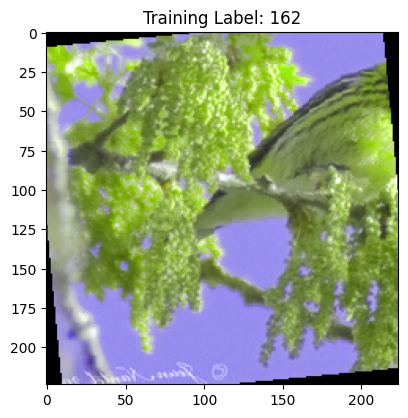

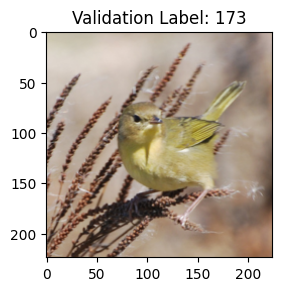

In [2]:
import matplotlib.pyplot as plt

def imshow(img, title=None):
    # Unnormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # Convert from Tensor image
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
train_images, train_labels = next(iter(DataLoader(train_dataset, batch_size=1, shuffle=True)))

# Get a batch of validation data
val_images, val_labels = next(iter(DataLoader(val_dataset, batch_size=1, shuffle=True)))

# Plot images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(train_images[0], title=f'Training Label: {train_labels[0]}')
plt.subplot(1, 2, 2)
imshow(val_images[0], title=f'Validation Label: {val_labels[0]}')
plt.show()

2.加载预训练模型

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, 200)  
)
for param in model.parameters():
    param.requires_grad = True
initial_state = copy.deepcopy(model.state_dict())
model = model.to(device)
print(device)
print(model)

/home/nvidia/anaconda3/envs/agcl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nvidia/anaconda3/envs/agcl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [5]:
import matplotlib.pyplot as plt
def train(model,train_dataset,val_dataset,batch_size=32,lr=0.0001,epoch=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
    val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
    losses=[]
    train_acces=[]
    val_acces=[]
    best_acc=0
    best_epoch=0
    for i in range(epoch):
        model.train()
        running_loss = 0
        running_correct = 0
        total_train = 0
        for batch in train_dataloader:
            img,label=batch
            optimizer.zero_grad()
            img=img.to(device)
            label=label.to(device)
            output=model(img)
            train_loss=criterion(output,label)
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item() * img.size(0)
            _, predicted = torch.max(output, 1)
            running_correct += (predicted == label).sum().item()
            total_train += label.size(0)
            train_loss = running_loss / total_train
        train_acc = running_correct / total_train
        losses.append(train_loss)
        train_acces.append(train_acc)
        model.eval()
        val_loss = 0
        correct = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_dataloader:
                img, label = batch
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item() * img.size(0)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total_val += label.size(0)
        val_epoch_loss = val_loss / total_val
        val_epoch_acc = correct / total_val
        val_acces.append(val_epoch_acc)
        print(f'Epoch [{i+1}/{epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_epoch = i
            best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Best epoch: {best_epoch+1} with accuracy: {best_acc:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss over Epochs')
    plt.plot(losses, label='Train Loss')
    plt.plot(val_acces, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
            
    plt.subplot(1, 2, 2)
    plt.title('Accuracy over Epochs')
    plt.plot(train_acces, label='Train Accuracy')
    plt.plot(val_acces, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    model.load_state_dict(best_model_wts)
    return model

/home/nvidia/anaconda3/envs/agcl/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Train Loss: 4.9303, Train Acc: 0.0471, Val Loss: 3.5240, Val Acc: 0.2782
Epoch [2/100], Train Loss: 3.8181, Train Acc: 0.1858, Val Loss: 2.5426, Val Acc: 0.4640
Epoch [3/100], Train Loss: 3.1880, Train Acc: 0.2982, Val Loss: 2.0729, Val Acc: 0.5394
Epoch [4/100], Train Loss: 2.7276, Train Acc: 0.3790, Val Loss: 1.6651, Val Acc: 0.6039
Epoch [5/100], Train Loss: 2.4267, Train Acc: 0.4374, Val Loss: 1.5076, Val Acc: 0.6370
Epoch [6/100], Train Loss: 2.1967, Train Acc: 0.4951, Val Loss: 1.3270, Val Acc: 0.6641
Epoch [7/100], Train Loss: 2.0252, Train Acc: 0.5223, Val Loss: 1.2255, Val Acc: 0.6913
Epoch [8/100], Train Loss: 1.8871, Train Acc: 0.5565, Val Loss: 1.1182, Val Acc: 0.7142
Epoch [9/100], Train Loss: 1.7619, Train Acc: 0.5842, Val Loss: 1.0861, Val Acc: 0.7125
Epoch [10/100], Train Loss: 1.6826, Train Acc: 0.5957, Val Loss: 1.0398, Val Acc: 0.7171
Epoch [11/100], Train Loss: 1.5804, Train Acc: 0.6169, Val Loss: 1.0183, Val Acc: 0.7294
Epoch [12/100], Train Loss: 1.

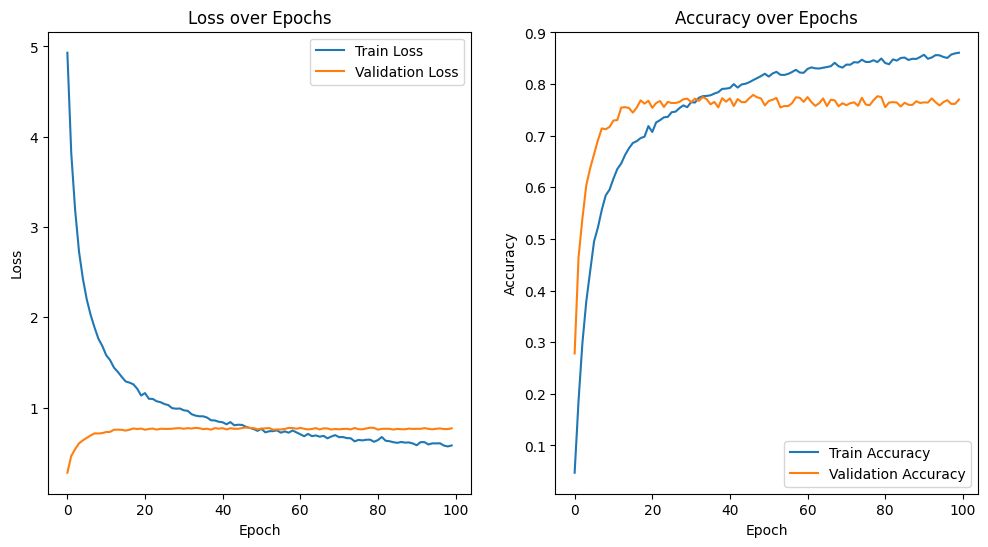

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
train(model,train_dataset,val_dataset,batch_size=32,lr=0.0001,epoch=100)

In [21]:
torch.save(model.state_dict,'model_weights_pre.pth')

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
best_acc = 0.0
best_settings = {}
def evaluate(model, data_set):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    data_loader=DataLoader(data_set,batch_size=batch_size,shuffle=False,num_workers=4)
    with torch.no_grad():  
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
    accuracy = correct / total
    return accuracy
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Testing with learning rate: {lr} and batch size: {batch_size}")
        model.load_state_dict(copy.deepcopy(initial_state))
        train(model,train_dataset,val_dataset,batch_size=batch_size,lr=lr,epoch=100)
        current_acc = evaluate(model, val_dataset)
        if current_acc > best_acc:
            best_acc = current_acc
            best_settings = {'lr': lr, 'batch_size': batch_size}
            print(f"New best accuracy: {best_acc} with learning rate {lr} and batch size {batch_size}")
print(f"Best settings found: {best_settings} with accuracy {best_acc}")